<a href="https://colab.research.google.com/github/minjae0501/yolo_block/blob/master/lstm_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/minjae0501/yolo_block.git

Cloning into 'yolo_block'...
remote: Enumerating objects: 3005, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3005 (delta 1), reused 11 (delta 1), pack-reused 2993
Receiving objects: 100% (3005/3005), 106.78 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
# %pip install mediapipe
# %pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.9.13 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)
Setup complete ✅ (8 CPUs, 15.9 GB RAM, 210.2/232.3 GB disk)


In [3]:
import cv2
import mediapipe as mp
from ultralytics import YOLO
import numpy as np

In [3]:
# cv2.destroyAllWindows()

# 직접 데이터 만들기

In [4]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# YOLO 객체 감지 모델 초기화
best_model = 'block_best_02.pt'
yolo_model = YOLO(best_model)

def show_hand(video_path, interval, detect_cls, hand_cls):
  xyz_list_list = []
  hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.3)

  cap = cv2.VideoCapture(video_path)
  if cap.isOpened():
    cnt = 0
    while True:
      ret, img = cap.read()
      if cnt == interval and ret == True:
        cnt = 0
        xyz_list = []
        img = cv2.resize(img, (640,640))
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        #Hand_landmarks
        if not results.multi_hand_landmarks:
          continue

        for x_y_z in results.multi_hand_landmarks:
          for landmark in x_y_z.landmark:
            xyz_list.append(landmark.x)
            xyz_list.append(landmark.y)
            xyz_list.append(landmark.z)


        # YOLO 박스
        box_results = yolo_model.predict(img, conf = 0.6)
        box_results = box_results[0].boxes
        boxes = box_results.xyxy.cpu().tolist()
        box_class = box_results.cls.cpu().tolist()
        confs = box_results.conf.float().cpu().tolist()


        # YOLO 박스 좌표
        x1, y1, x2, y2 = 0,0,0,0
        hx1, hy1, hx2, hy2 = 0,0,0,0
        for idx, cls in enumerate(box_class):
          if int(cls) == detect_cls:
            x1, y1, x2, y2 = boxes[idx]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
          elif int(cls) == hand_cls:
            hx1, hy1, hx2, hy2 = boxes[idx]
            hx1, hy1, hx2, hy2 = int(hx1), int(hy1), int(hx2), int(hy2)

        if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
          continue
        if hx1 == 0 and hy1 == 0 and hx2 == 0 and hy2 == 0:
          continue

        xyz_list.append(abs(x1-hx1)/640)
        xyz_list.append(abs(x2-hx2)/640)
        xyz_list.append(abs(y1-hy1)/640)
        xyz_list.append(abs(y2-hy2)/640)

        # xyz_list.append(x1)
        # xyz_list.append(y1)
        # xyz_list.append(x2)
        # xyz_list.append(y2)
        # xyz_list.append(hx1)
        # xyz_list.append(hy1)
        # xyz_list.append(hx2)
        # xyz_list.append(hy2)



        # dataset append
        xyz_list_list.append(xyz_list)


        # cv2.imshow('Hand Landmarks', img)
        cv2.waitKey(1)
      elif ret == False:
        break
      cnt += 1
  cap.release()
  # cv2.destroyAllWindows()
  return xyz_list_list #+  xyz_list_list_flip

In [5]:
import os
import random

video_path = './data/video_data/train'
video_name_list = os.listdir(video_path)
dataset = []
length = 20
interval = 1
detect_cls = 0
hand_cls = 6

for video_name in video_name_list:
  if 'release' in video_name: label = 0
  else: label = 1
  hand_data = show_hand('{}/{}'.format(video_path, video_name), interval, detect_cls, hand_cls)
  # for idx in range(0, len(hand_data), int(length/2)):
  for idx in range(0, len(hand_data), int(length)):
    seq_list = hand_data[idx : idx + length]
    if len(seq_list) == length:
      dataset.append({'key': label, 'value' : seq_list})

random.shuffle(dataset)



0: 640x640 1 blue_bridge, 1 hand, 12.0ms
Speed: 4.0ms preprocess, 12.0ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 hand, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 hand, 10.0ms
Speed: 4.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 hand, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 hand, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 hand, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 hand, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 blue_bridge, 1 ha

In [6]:
print(len(dataset))

399


In [7]:
for data in dataset:
    for value in data['value']:
        print(len(value))
        # print(value)
        break
    break

67


# 데이터셋 파일 불러오기

In [16]:
import torch

if torch.cuda.is_available() == True:
    device = 'cuda:0'
else:
    device = 'cpu'

print(device)

cuda:0


In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [6]:
import pickle
# 데이터셋 파일 불러오기
def load_dataset(file_name):
    with open(file_name, "rb") as file:
        return pickle.load(file)
    
# 데이터 로드
data_path = "./data/more_training_dataset_ver3.pkl"
dataset = load_dataset(data_path)

In [130]:
print(len(dataset))

1152


In [131]:
for data in dataset:
    for value in data['value']:
        print(len(value))
        # print(value)
        break
    break

67


In [220]:
split_ratio = [0.6, 0.3, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len

In [221]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, vaild_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=8)
val_loader = DataLoader(vaild_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

In [222]:
class hand_LSTM(nn.Module): #more_data_lstm_model_ver4
    def __init__(self):
        super(hand_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size = 67, hidden_size = 128, num_layers=1, batch_first=True) 
        self.dropout1 = nn.Dropout(0.1)

        self.lstm2 = nn.LSTM(input_size = 128, hidden_size = 64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)

        self.lstm3 = nn.LSTM(input_size = 64, hidden_size = 32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1,:])
        return x

In [223]:
import matplotlib.pyplot as plt
from torch.optim import Adam

def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = hand_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr = 0.001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [],[],[],[],[]
    log_stack, time_log = [], []

In [224]:
def record_train_log(_tloss, _tacc, _time):
    # train log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # validation log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) -1]
    else:
        return -1

from IPython.display import clear_output

def print_log():
    # 학습 추이 출력

    # 소숫점 3자리 수까지 조절
    trian_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5}| V_Loss {:5}| V_acc {:5} | {:5}'.format(last(iter_log), trian_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str) #프린트 준비

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize= (10, 3), dpi = 99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정

    # loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color= 'red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color= 'blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line #위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid()
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])


In [225]:
import gc
from torch.cuda import memory_allocated, empty_cache

def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'trian'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration학습 알고리즘(for문 나오면 1epoch완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        if mode == 'train':
            net.train()
        else:
            net.eval()

        result = net(data)
        _, out = torch.max(result, 1)

        # 2. loss 계산
        loss = loss_fn(result, label)
        iter_loss.append(loss.item())

        # 3. 역전파 학습후 gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # gradient Descent수행
            last_grad_performed = True #for문 나가면 epoch카운터 +=1

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())
    # 역전파 학습 후 epoch카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # epoch이 끝남을 알림
    return epoch_cnt < maximum_epoch

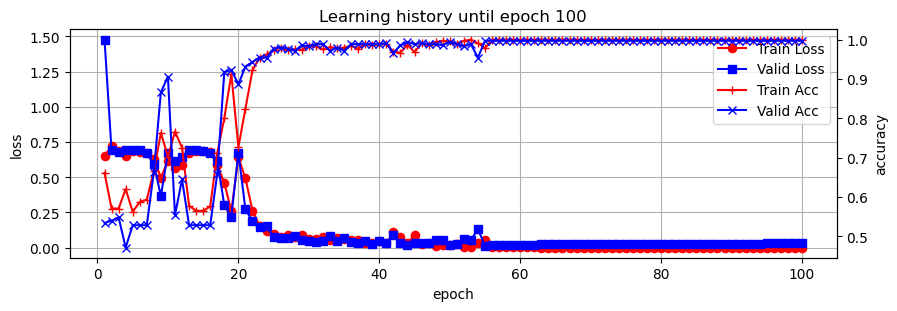

Epoch: 100 | T_Loss   0.0 | T_acc   1.0| V_Loss  0.03| V_acc 0.997 |  0.67
Epoch:  99 | T_Loss   0.0 | T_acc   1.0| V_Loss  0.03| V_acc 0.997 | 0.701
Epoch:  98 | T_Loss   0.0 | T_acc   1.0| V_Loss  0.03| V_acc 0.997 |  0.67
Epoch:  97 | T_Loss   0.0 | T_acc   1.0| V_Loss  0.03| V_acc 0.997 | 0.716
Epoch:  96 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.029| V_acc 0.997 | 0.733
Epoch:  95 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.029| V_acc 0.997 |  0.76
Epoch:  94 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.029| V_acc 0.997 | 0.776
Epoch:  93 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.029| V_acc 0.997 | 0.731
Epoch:  92 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.029| V_acc 0.997 | 0.767
Epoch:  91 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.029| V_acc 0.997 | 0.736
Epoch:  90 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.028| V_acc 0.997 | 0.727
Epoch:  89 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.028| V_acc 0.997 | 0.685
Epoch:  88 | T_Loss   0.0 | T_acc   1.0| V_Loss 0.028| V_acc 0.997 | 0.834
Epoch:  87 | T_Loss   0.0

In [226]:
# training initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 100

# training iteration
import time

while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad(): # 역전파 학습을 하지 말도록
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

In [227]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc: 1.0
Test Loss: 0.0


In [228]:
# 모델을 저장할 파일 경로
model_path = './lstm_pth/more_data_lstm_model_ver7.pth'

# 모델 저장
torch.save(net.state_dict(), model_path)
print("모델이 저장되었습니다.")

모델이 저장되었습니다.
